In [1]:
import geopandas as gpd
import geojsonio as geoio
import pandas as pd
from collections import defaultdict
from shapely.geometry import Point, Polygon
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

# Read Data 

In [2]:
vancouver_all_data = gpd.read_file('VancouverAllData.geojson')
vancouver_gdf = gpd.GeoDataFrame({'population':vancouver_all_data['pop'], 'geometry':vancouver_all_data['geometry']})
vancouver_gdf = vancouver_gdf.reset_index()

osm_data = pd.read_json('osm/amenities-vancouver.json.gz', lines=True, compression='gzip')


# Data Cleaning

In [3]:
# Cleaning: convert population to numeric
vancouver_gdf['population'] = pd.to_numeric(vancouver_gdf['population'])

# Cleaning: Form a coordinate point using lon and lat
osm_data['geometry'] = list(zip(osm_data['lon'],osm_data['lat']))
osm_data['geometry'] = osm_data['geometry'].apply(Point)
# Cleaning: Set the amenity name of all skytrain station
osm_data.loc[(osm_data['name'].str.contains('Station')) & (osm_data['amenity'] == 'bus_station'), 'amenity'] = 'skytrain_station'
# Cleaning: While creating gdf, lower case all amenities names
osm_gdf = gpd.GeoDataFrame({'amenity':osm_data['amenity'].apply(lambda x: x.lower()), 'geometry':osm_data['geometry']}, geometry='geometry', crs=vancouver_gdf.crs)

In [4]:
# we did this to verify that .explode and .area compute the same area 
# vancouver_gdf_explode = vancouver_gdf.explode('geometry')
# vancouver_gdf_explode['area'] = vancouver_gdf_explode['geometry'].area
# vancouver_gdf_explode
# vancouver_gdf.max()

# Data Prep

In [5]:
# Calculate population density based on the give population and relative area 
vancouver_gdf['area'] = vancouver_gdf['geometry'].area
vancouver_gdf['population_density'] = vancouver_gdf['population'] / (vancouver_gdf['area'] * 1000)

# use spatial join to match points (osm data) and multipolygons (vancouver data)
pointInPolys = gpd.tools.sjoin(osm_gdf, vancouver_gdf, op="within", how='left')
# index_right is the index of the joined multipolygon, i.e. ID of an area
# group by area and for each area, get the list of amenities located in this area
amenitiesInEachArea = pointInPolys.groupby(['index_right'])['amenity'].apply(list)
amenitiesInEachArea
# count the number of each amenity in the area and put it into dict
amenitiesInEachArea = amenitiesInEachArea.apply(lambda x: Counter(x))
amenitiesInEachArea
vancouver_gdf['amenities'] = amenitiesInEachArea
# split the dict column into separate columns
vancouver_gdf = pd.concat([vancouver_gdf.drop(['amenities'], axis=1), vancouver_gdf['amenities'].apply(pd.Series)], axis=1)
# fill all NaN values with 0 and drop redundant columns
vancouver_gdf = vancouver_gdf.drop([0, 'index'], axis=1).fillna(0)
vancouver_gdf

/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_3818/41669226.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  vancouver_gdf['area'] = vancouver_gdf['geometry'].area
/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,population,geometry,area,population_density,shelter,post_box,bank,fast_food,restaurant,bench,...,hunting_stand,waste_transfer_station,vacuum_cleaner,lounge,evse,storage_rental,atm;bank,healthcare,stripclub,money_transfer
0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",0.000126,48910.333782,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,8245,"MULTIPOLYGON (((-123.02353 49.20818, -123.0234...",0.000229,35926.018931,1.0,1.0,5.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6949,"MULTIPOLYGON (((-123.04245 49.20549, -123.0426...",0.000239,29018.934041,0.0,1.0,0.0,0.0,1.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",0.000097,40318.042652,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",0.000095,47558.899022,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,3530,"MULTIPOLYGON (((-122.57911 49.17246, -122.5788...",0.000646,5462.802541,1.0,0.0,0.0,1.0,12.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,96,"MULTIPOLYGON (((-122.56953 49.17974, -122.5694...",0.000216,445.127637,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
486,6228,"MULTIPOLYGON (((-122.46134 49.16769, -122.4613...",0.007359,846.345399,0.0,1.0,0.0,3.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
487,4255,"MULTIPOLYGON (((-122.45998 49.07500, -122.4598...",0.000378,11259.178637,0.0,0.0,0.0,2.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data Processing

Scale data accroding to the amenities scoring

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density'], axis=1).values
y = vancouver_gdf['population_density'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# train model
model = make_pipeline(
        StandardScaler(),
        PCA(40),
        PolynomialFeatures(degree=1, include_bias=True),
        LinearRegression(fit_intercept=False)
)

model.fit(X_train, y_train)
# validate model
# check r^2 instead of .score
print(model.score(X_valid, y_valid))
predicted_y = model.predict(vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density'], axis=1).values)
# print(len(X))
# print(len(predicted_y))


0.3685156722873426


(489, 122)
(478,)


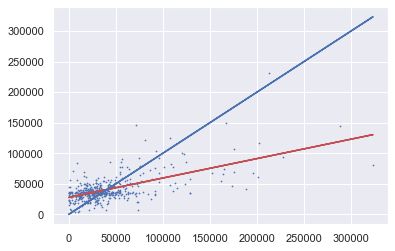

In [7]:
import seaborn

# filter out negative scores for the predicted labels 
data = pd.DataFrame({'y': y, 'predicted_y': predicted_y})
data = data[data['predicted_y'] > 0]
y = data['y']
predicted_y = data['predicted_y']

y_stack = np.stack([y], axis=1)

model = LinearRegression(fit_intercept=True)
model.fit(y_stack, predicted_y)
best_fit = model.intercept_ + model.coef_[0] * y_stack


seaborn.set()
plt.scatter(y_stack, predicted_y, s=0.5)
plt.plot(y_stack, best_fit, '-r')
plt.plot(y, y, 'b-')
# predicted_population = np.moveaxis(predicted_population, 1, 0)

print(X.shape)
print(predicted_y.shape)


Make a residual plot

(array([  8., 188., 213.,  41.,  13.,   8.,   6.,   0.,   0.,   1.]),
 array([-74667.5429571 , -42916.68499763, -11165.82703816,  20585.0309213 ,
         52335.88888077,  84086.74684024, 115837.6047997 , 147588.46275917,
        179339.32071864, 211090.17867811, 242841.03663757]),
 <BarContainer object of 10 artists>)

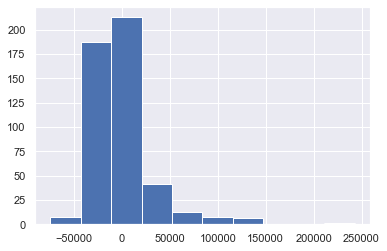

In [8]:
residuals = y - predicted_y
seaborn.set()
plt.hist(residuals)

# Heatmap

Used predicted y label and the original y label to compute the percentage difference and produce the heatmap based on it


In [9]:
vancouver_gdf['predicted_population_density_difference'] = vancouver_gdf["population_density"] - predicted_y
vancouver_gdf['percentage_difference'] = (vancouver_gdf['predicted_population_density_difference'] / vancouver_gdf['population_density']) * 100

# background-image: linear-gradient(to right, #eb164d, #d6427a, #b66195, #96759a, #8d729d, #826fa0, #756da3, #685bb9, #5648cd, #3e30df, #0d00f0);
# background-image: linear-gradient(to right,  #ff3d61, #, #, #, #, #, #, #, #, #);
# background-image: linear-gradient(to right, , #ff3d61, #ff73a6, #ffa4da, #f4cff8, #, #, #, #, #, #);

def getColorFromPercentage(percentage):
    if percentage < -80:
        return '#8b7efd'
    elif percentage < -60:
        return '#a89bff'
    elif percentage < -40:
        return '#c3b9ff'
    elif percentage < -20:
        return '#ddd7ff'
    elif percentage < 0:
        return '#e4d4fe'
    elif percentage > 80:
        return '#ff3d61'
    elif percentage > 60:
        return '#ff73a6'
    elif percentage > 40:
        return '#ffa4da'
    elif percentage > 20:
        return '#f4cff8'
    elif percentage >= 0:
        return '#ecd2fc'

vancouver_gdf["amenity_count"] = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference'], axis=1).sum(axis=1)
vancouver_gdf['fill'] = vancouver_gdf['percentage_difference'].apply(lambda percentage: getColorFromPercentage(percentage))
heatmap_gdf = gpd.GeoDataFrame({'geometry':vancouver_gdf['geometry'], 'fill':vancouver_gdf['fill'], 'pop_dens': vancouver_gdf['population_density'], 'amenity_count': vancouver_gdf['amenity_count']})
heatmap_gdf
heatmap_gdf.to_file('heatmap.geojson', driver="GeoJSON")
contents = gpd.read_file('heatmap.geojson')
geoio.display(contents)


/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


'http://geojson.io/#id=gist:/51d7d3fd08c848c91c714e54347b84f7'

# Statistical Analysis

TODO: change
Split data into overpopulated and underpopulated 

In [10]:
red_areas = vancouver_gdf[vancouver_gdf['percentage_difference'] > 0]
blue_areas = vancouver_gdf[vancouver_gdf['percentage_difference'] <= 0]
red_areas


,population,geometry,area,population_density,shelter,post_box,bank,fast_food,restaurant,bench,...,evse,storage_rental,atm;bank,healthcare,stripclub,money_transfer,predicted_population_density_difference,percentage_difference,amenity_count,fill
0,6154,"MULTIPOLYGON (((-123.02353 49.20818, -123.0235...",0.000126,48910.333782,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,13488.883389,27.578801,0.0,#f4cff8
3,3908,"MULTIPOLYGON (((-123.05918 49.21162, -123.0597...",0.000097,40318.042652,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,468.266393,1.161431,4.0,#ecd2fc
4,4527,"MULTIPOLYGON (((-123.05918 49.21162, -123.0587...",0.000095,47558.899022,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2700.935829,5.679139,3.0,#ecd2fc
5,3703,"MULTIPOLYGON (((-123.07203 49.21459, -123.0727...",0.000067,55275.867375,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,24326.491464,44.009244,6.0,#ffa4da
9,7151,"MULTIPOLYGON (((-123.11705 49.21024, -123.1170...",0.000169,42257.444457,0.0,2.0,0.0,3.0,7.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,23503.372467,55.619484,35.0,#ffa4da
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,7336,"MULTIPOLYGON (((-122.84559 49.17706, -122.8454...",0.000080,91509.677613,0.0,3.0,0.0,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,52554.236870,57.430250,11.0,#ffa4da
449,9821,"MULTIPOLYGON (((-122.84559 49.17706, -122.8457...",0.000164,59975.124518,0.0,6.0,6.0,20.0,15.0,34.0,...,0.0,0.0,0.0,0.0,0.0,1.0,17752.777725,29.600235,138.0,#f4cff8
451,2917,"MULTIPOLYGON (((-122.84531 49.20618, -122.8453...",0.000062,47233.064422,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,11077.121806,23.452050,2.0,#f4cff8
452,4363,"MULTIPOLYGON (((-122.84719 49.20023, -122.8468...",0.000090,48720.897130,0.0,4.0,2.0,1.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,17307.203906,35.523163,34.0,#f4cff8


Now we find what amenities are important in red areas and in blue areas

In [11]:
red_areas_amenities = red_areas.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference', 'amenity_count'], axis=1)
red_areas_amenities_avg = red_areas_amenities.mean().sort_values(ascending=False)

blue_areas_amenities = blue_areas.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference', 'amenity_count'], axis=1)
blue_areas_amenities_avg = blue_areas_amenities.mean().sort_values(ascending=False)

red_and_blue_avg = pd.concat([red_areas_amenities_avg, blue_areas_amenities_avg], axis=1).rename({0: 'red_avg', 1:'blue_avg'}, axis=1)
red_and_blue_avg


/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_3818/3895382976.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  red_areas_amenities_avg = red_areas_amenities.mean().sort_values(ascending=False)
/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_3818/3895382976.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  blue_areas_amenities_avg = blue_areas_amenities.mean().sort_values(ascending=False)


,red_avg,blue_avg
bench,7.026882,5.585616
restaurant,5.526882,3.969178
bicycle_parking,4.010753,2.034247
cafe,2.204301,1.760274
fast_food,1.747312,2.010274
...,...,...
courthouse,0.000000,0.006849
nursery,0.000000,0.003425
loading_dock,0.000000,0.003425
training,0.000000,0.003425


we did the T-test on whether the avg num of amenities in red differ from the avg num of amenities in blue since the variances are close but the data is not normal

we then confirmed the results using mannwhitneyu

In [12]:
red_and_blue_avg = red_and_blue_avg.dropna()

from scipy import stats
print('Normality test: ', stats.normaltest(red_and_blue_avg['red_avg']).pvalue)
print('Levene\'s test: ', stats.levene(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg']).pvalue)

ttest = stats.ttest_ind(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg'])
print('T-test p-value:', ttest.pvalue)
print('Mann-Wittney p-value: ', stats.mannwhitneyu(red_and_blue_avg['red_avg'], red_and_blue_avg['blue_avg']).pvalue)


Normality test:  1.006154801627633e-37
Levene's test:  0.6337542289725178
T-test p-value: 0.626773646403286
Mann-Wittney p-value:  0.48245596957682224


Since p-value is high, we failed to reject H0 (which is red=blue), and we conclude that the avg num of amenities in red doesn't differ from the avg num of amenities in blue

number of amenities and population density of the area are slightly positvely correlated

In [13]:
red_areas['amenity_count'].corr(red_areas['population_density'])

0.44023310342223915

Find the correlations between population density and individula amenity types. <br>
Note: nan means values do not vary as per https://stackoverflow.com/questions/22655667/dataframe-correlation-produces-nan-although-its-values-are-all-integers answered by Karl D.

In [14]:
red_areas_amenities_ = red_areas_amenities.drop(['fill'], axis=1)
correlations = {}
for col in red_areas_amenities_:
    # print(red_areas_amenities[col], red_areas['population_density'])
    correlations[col] = red_areas_amenities_[col].corr(red_areas['population_density'])
correlations = dict(sorted(correlations.items(), key=lambda item: abs(item[1]), reverse=True))
correlations

{'skytrain_station': nan,
 'car_sharing': 0.6063349163218218,
 'bicycle_rental': 0.587845223791429,
 'bar': 0.5758197071056975,
 'cafe': 0.4476670527640381,
 'fast_food': 0.417673508666624,
 'nightclub': 0.40027261937906955,
 'restaurant': 0.39504828587384316,
 'post_box': 0.39179713185431664,
 'pub': 0.3323224128574638,
 'bench': 0.29855677518564194,
 'cinema': 0.2957974490677174,
 'fountain': 0.2874285733817054,
 'post_office': 0.285356063770918,
 'car_rental': 0.2852123871158773,
 'bicycle_parking': 0.27820364029453026,
 'waste_basket': 0.2771580358336265,
 'clinic': 0.23900974027632985,
 'bank': 0.2353271170185326,
 'bureau_de_change': 0.2302379591249954,
 'pharmacy': 0.22547199621153374,
 'fuel': -0.2035265865178166,
 'community_centre': 0.20129471869594126,
 'parking_entrance': 0.188288317391775,
 'dentist': 0.18350337052189344,
 'ice_cream': 0.17771412565091027,
 'shelter': -0.17179284141901477,
 'drinking_water': 0.1664066295743165,
 'atm': 0.14591809961519359,
 'public_bookcas

In [15]:
amenities_all = vancouver_gdf.drop(['population',	'geometry',	'area',	'population_density', 'fill', 'predicted_population_density_difference', 'percentage_difference', 'amenity_count'], axis=1)
correlations_all = {}
for col in amenities_all:
    correlations_all[col] = amenities_all[col].corr(vancouver_gdf['population_density'])
correlations_all = dict(sorted(correlations_all.items(), key=lambda item: abs(item[1]), reverse=True))
correlations_all

{'car_sharing': 0.4538068929515993,
 'bicycle_rental': 0.4008092421308648,
 'restaurant': 0.3420118921379561,
 'cafe': 0.31750239108830797,
 'nightclub': 0.31287804500403804,
 'payment_terminal': 0.2846412650139021,
 'bar': 0.2682330576752724,
 'post_box': 0.2655933777608025,
 'bicycle_parking': 0.26213935171312913,
 'pharmacy': 0.23622629344958102,
 'bank': 0.23462646356187986,
 'fast_food': 0.22313617382523693,
 'cinema': 0.22189291835812588,
 'pub': 0.21763031730334703,
 'dentist': 0.214800814920946,
 'training': 0.1987285163827025,
 'community_centre': 0.19327285347250212,
 'post_office': 0.18422663909554823,
 'clinic': 0.18347910163937617,
 'bench': 0.17182473831668085,
 'internet_cafe': 0.16522324601608318,
 'ice_cream': 0.16147964794900174,
 'car_rental': 0.1543315307492778,
 'taxi': 0.1500385578937241,
 'parking_entrance': 0.14526041434564363,
 'shelter': -0.13203773753034728,
 'fuel': -0.12589371071493277,
 'toilets': -0.12541213153982927,
 'bureau_de_change': 0.12483176014441

In [16]:
import json

with open('file.json', 'w') as file:
     file.write(json.dumps(correlations_all)) # use `json.loads` to do the reverse

In [17]:
import json
import math

with open("file.json") as f:
    data = f.read()
scores = json.loads(data)

for k,v in scores.items():
    if math.isnan(v):
        scores[k] = 0

# df_train = vancouver_gdf.drop(['population', 'area', 'population_density', 'geometry'], axis=1)
# # df_train += 1
scores_vector = []
for i in range(len(amenities_all.columns)):
    scores_vector.append(scores[amenities_all.columns[i]])
scores_vector

scaled_train = amenities_all * scores_vector * 100
scaled_train
# scaled_df_train["sum"] = scaled_df_train.sum(axis=1)
# scaled_df_train['population_density'] = vancouver_gdf['population_density']
# # scaled_df_train = scaled_df_train[(scaled_df_train['sum'] < 1000) & (scaled_df_train['sum'] > 50)]
# scaled_df_train
# # plt.scatter(scaled_df_train['sum'], scaled_df_train['population_density'], 0.5)

,shelter,post_box,bank,fast_food,restaurant,bench,fuel,library,cafe,post_office,...,hunting_stand,waste_transfer_station,vacuum_cleaner,lounge,evse,storage_rental,atm;bank,healthcare,stripclub,money_transfer
0,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
1,-13.203774,26.559338,117.313232,66.940852,68.402378,17.182474,-12.589371,-0.485914,63.500478,18.422664,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
2,-0.000000,26.559338,0.000000,0.000000,34.201189,223.372160,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
3,-0.000000,26.559338,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.485914,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
4,-0.000000,53.118676,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,-13.203774,0.000000,0.000000,22.313617,410.414271,309.284529,-12.589371,-0.485914,222.251674,18.422664,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
485,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
486,-0.000000,26.559338,0.000000,66.940852,68.402378,85.912369,-12.589371,-0.000000,31.750239,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
487,-0.000000,0.000000,0.000000,44.627235,102.603568,17.182474,-0.000000,-0.000000,95.250717,0.000000,...,-0.0,-0.0,-0.000000,-0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

X = scaled_train.values
y = vancouver_gdf['population_density'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y)

# train model
model = make_pipeline(
        StandardScaler(),
        PCA(40),
        PolynomialFeatures(degree=1, include_bias=True),
        LinearRegression(fit_intercept=False)
)

model.fit(X_train, y_train)
# validate model
# check r^2 instead of .score
print(model.score(X_valid, y_valid))
predicted_y = model.predict(vancouver_gdf.drop(['population','geometry','area', 'population_density', 'fill', 'predicted_population_density_difference', 'percentage_difference', 'amenity_count'], axis=1).values)
# print(len(X))
# print(len(predicted_y))

0.15995294398326265


In [22]:
vancouver_gdf['predicted_population_density_difference'] = vancouver_gdf["population_density"] - predicted_y
vancouver_gdf['percentage_difference'] = (vancouver_gdf['predicted_population_density_difference'] / vancouver_gdf['population_density']) * 100

# background-image: linear-gradient(to right, #eb164d, #d6427a, #b66195, #96759a, #8d729d, #826fa0, #756da3, #685bb9, #5648cd, #3e30df, #0d00f0);
# background-image: linear-gradient(to right,  #ff3d61, #, #, #, #, #, #, #, #, #);
# background-image: linear-gradient(to right, , #ff3d61, #ff73a6, #ffa4da, #f4cff8, #, #, #, #, #, #);

def getColorFromPercentage(percentage):
    if percentage < -80:
        return '#8b7efd'
    elif percentage < -60:
        return '#a89bff'
    elif percentage < -40:
        return '#c3b9ff'
    elif percentage < -20:
        return '#ddd7ff'
    elif percentage < 0:
        return '#e4d4fe'
    elif percentage > 80:
        return '#ff3d61' # red
    elif percentage > 60:
        return '#ff73a6'
    elif percentage > 40:
        return '#ffa4da'
    elif percentage > 20:
        return '#f4cff8'
    elif percentage >= 0:
        return '#ecd2fc'

vancouver_gdf["amenity_count"] = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference'], axis=1).sum(axis=1)
vancouver_gdf['fill'] = vancouver_gdf['percentage_difference'].apply(lambda percentage: getColorFromPercentage(percentage))
heatmap_gdf = gpd.GeoDataFrame({'geometry':vancouver_gdf['geometry'], 'fill':vancouver_gdf['fill'], 'pop_dens': vancouver_gdf['population_density'], 'amenity_count': vancouver_gdf['amenity_count']})
heatmap_gdf
heatmap_gdf.to_file('heatmap-weighted.geojson', driver="GeoJSON")
contents = gpd.read_file('heatmap-weighted.geojson')
geoio.display(contents)


/var/folders/dd/2sk2zf7j1wv0jkhkwl_3450h0000gn/T/ipykernel_3818/3101178651.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  vancouver_gdf["amenity_count"] = vancouver_gdf.drop(['population', 'geometry', 'area', 'population_density', 'predicted_population_density_difference',	'percentage_difference'], axis=1).sum(axis=1)
/Users/raufshimarov/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


'http://geojson.io/#id=gist:/eaefad01f9edf07345f19adcb759745d'